Epoch [1/25], Train Loss: 0.8946, Val Loss: 0.9477
Epoch [2/25], Train Loss: 0.8544, Val Loss: 0.9315
Epoch [3/25], Train Loss: 0.8231, Val Loss: 0.8948
Epoch [4/25], Train Loss: 0.7922, Val Loss: 0.8461
Epoch [5/25], Train Loss: 0.7580, Val Loss: 0.8006
Epoch [6/25], Train Loss: 0.7344, Val Loss: 0.7618
Epoch [7/25], Train Loss: 0.7052, Val Loss: 0.7371
Epoch [8/25], Train Loss: 0.6831, Val Loss: 0.7243
Epoch [9/25], Train Loss: 0.6684, Val Loss: 0.7162
Epoch [10/25], Train Loss: 0.6567, Val Loss: 0.7146
Epoch [11/25], Train Loss: 0.6446, Val Loss: 0.6997
Epoch [12/25], Train Loss: 0.6350, Val Loss: 0.6842
Epoch [13/25], Train Loss: 0.6258, Val Loss: 0.6689
Epoch [14/25], Train Loss: 0.6168, Val Loss: 0.6518
Epoch [15/25], Train Loss: 0.6088, Val Loss: 0.6316
Epoch [16/25], Train Loss: 0.6027, Val Loss: 0.6096
Epoch [17/25], Train Loss: 0.5969, Val Loss: 0.5911
Epoch [18/25], Train Loss: 0.5923, Val Loss: 0.5850
Epoch [19/25], Train Loss: 0.5873, Val Loss: 0.5774
Epoch [20/25], Train 

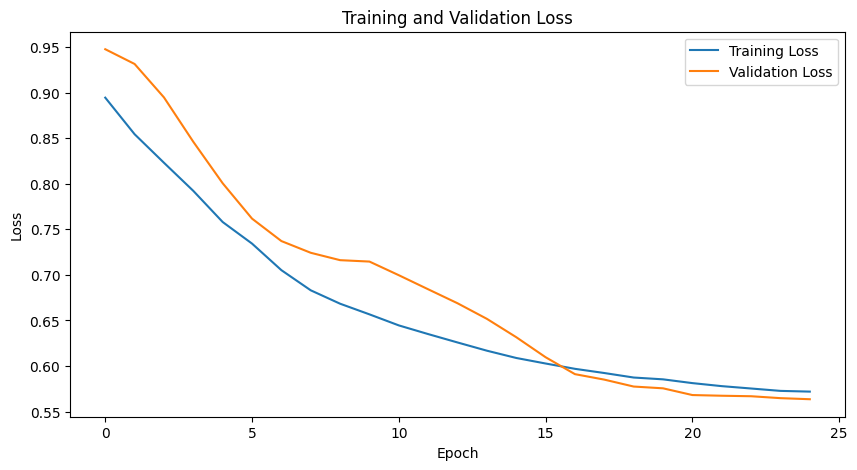

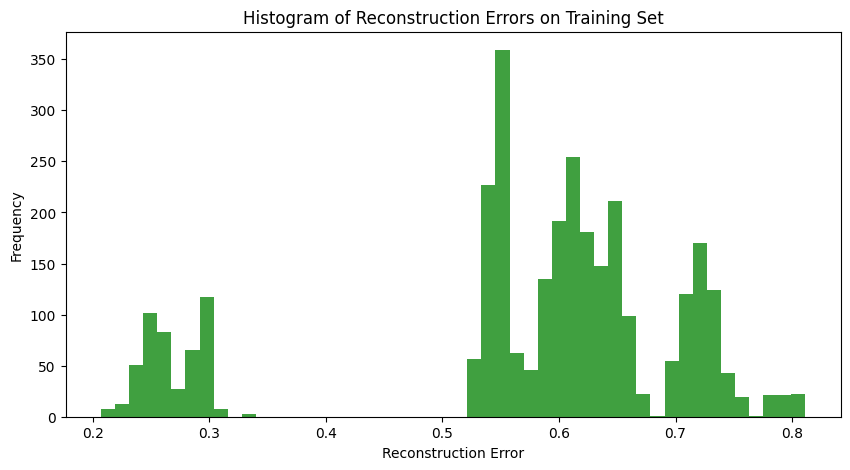

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
data_dir = 'data/'
train_dataset = ImageFolder( 'train1', transform=transform)
val_dataset = ImageFolder( 'val', transform=transform)
test_dataset = ImageFolder( 'test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

# Define the CAE2 model

class ConvAutoencoder(nn.Module):
    def __init__(self, color_mode='rgb'):
        super(ConvAutoencoder, self).__init__()

        # Define the number of channels based on the color mode
        channels = 1 if color_mode == 'grayscale' else 3

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=4, stride=2, padding=1),  # 64x64 -> 32x32
            nn.BatchNorm2d(32),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),        # 32x32 -> 16x16
            nn.BatchNorm2d(32),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=4, stride=2, padding=1),        # 16x16 -> 8x8
            nn.BatchNorm2d(32),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),        # 8x8 -> 8x8
            nn.BatchNorm2d(32),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),        # 8x8 -> 4x4
            nn.BatchNorm2d(64),
            #nn.LeakyReLU(0.3, i`nplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),        # 4x4 -> 4x4
            nn.BatchNorm2d(64),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),       # 4x4 -> 2x2
            nn.BatchNorm2d(128),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),       # 2x2 -> 2x2
            nn.BatchNorm2d(64),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),        # 2x2 -> 2x2
            nn.BatchNorm2d(32),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=2, stride=1, padding=0)          # 2x2 -> 1x1
        )

        # Decoder
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 32, kernel_size=4, stride=2, padding=1),    # 1x1 -> 2x2
            nn.BatchNorm2d(32),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 64, kernel_size=4, stride=2, padding=1),   # 2x2 -> 4x4
            nn.BatchNorm2d(64),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.BatchNorm2d(128),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.BatchNorm2d(64),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # 16x16 -> 32x32
            nn.BatchNorm2d(32),
            #nn.LeakyReLU(0.3, inplace=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),   # 32x32 -> 64x64

            nn.Sigmoid()  # Normalize to [0, 1]
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Example of usage
# Create the model
color_mode = 'rgb'  # or 'grayscale'
model = ConvAutoencoder(color_mode).to(device)
# Initialize the CAE2 model
#model = Autoencoder().to(device)
#criterion = nn.MSELoss()
import torch
import torch.nn.functional as F
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM

# Define a custom loss function combining MSE and SSIM
class CombinedLoss(torch.nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha  # Weighting factor between MSE and SSIM

    def forward(self, output, target):
        mse_loss = F.mse_loss(output, target)
        ssim_loss = 1 - ssim(output, target, data_range=target.max() - target.min(), size_average=True)
        combined_loss = self.alpha * mse_loss + (1 - self.alpha) * ssim_loss
        return combined_loss

# Usage in your training loop
criterion = CombinedLoss(alpha=0.5)  # You can adjust alpha to balance the losses

optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.1)
# Training the CAE2 model
num_epochs = 25
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation Phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, _ in val_loader:
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plot histogram of training reconstruction errors
model.eval()
train_reconstruction_errors = []
with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)
        outputs = model(images)
        #mse_loss = nn.functional.mse_loss(outputs, images, reduction='none').mean(dim=[1, 2, 3])
        for i in range(images.size(0)):  # Iterate over each image in the batch
            loss = criterion(outputs[i].unsqueeze(0), images[i].unsqueeze(0))
            train_reconstruction_errors.append(loss.item())
        #train_reconstruction_errors.extend(loss.cpu().numpy())

plt.figure(figsize=(10, 5))
plt.hist(train_reconstruction_errors, bins=50, alpha=0.75, color='green')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Histogram of Reconstruction Errors on Training Set')
plt.show()

In [ ]:
# Evaluate the CAE2 model on test set
model.eval()
reconstruction_errors = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        #mse_loss = nn.functional.mse_loss(outputs, images, reduction='none').mean([1, 2, 3])
        # Usage in your training loop
        criterion = CombinedLoss(alpha=0.5)
        for i in range(images.size(0)):  # Iterate over each image in the batch
            loss = criterion(outputs[i].unsqueeze(0), images[i].unsqueeze(0))
            reconstruction_errors.append(loss.item())

        #reconstruction_errors.extend(loss.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Classify test images as good (0) or anomaly (1) based on threshold
predicted_labels = [1 if (0.21<error<0.31) or (0.53<error<0.67) or (0.69<error < 0.76) or (0.78<error<0.81) else 0 for error in reconstruction_errors]

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')


Accuracy: 0.7710
